In [1]:
import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import DBLP

import numpy as np
import random

import matplotlib.pyplot as plt

##from modules.heteroGNN import HeteroGNN
#import graph_polluters
from tqdm import tqdm

# We initialize conference node features with a single one-vector as feature:
dataset = DBLP('./data/dblp', transform=T.Constant(node_types='conference'))
data = dataset[0]
print(data)


def set_seed(seed=42):
    #torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    #torch.use_deterministic_algorithms(True)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)


In [5]:
import torch_geometric.transforms as T
from modules.basic_link_pred import Model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(data.metadata(), hidden_channels=50, num_layers=10)

from_type, to_type = 'author', 'paper'
edge_type = ('author', 'to', 'paper')


transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.99,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=True,
    edge_types=("author", "to", "paper"),
    rev_edge_types=("paper", "to", "author")
)

train_data, val_data, test_data = transform(data)

model = model.to(device)
train_data = train_data.to(device)
val_data =  val_data.to(device)
with torch.no_grad():  # Initialize lazy modules.
    out = model(train_data, edge_type)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)

In [6]:
data

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [7]:
train_data

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={
    edge_index=[2, 158],
    edge_label=[46677],
    edge_label_index=[2, 46677],
  },
  (paper, to, author)={ edge_index=[2, 158] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [9]:
train_data['author','to','paper'].edge_label_index

tensor([[ 2080,  1800,   318,  ...,  1602,  3203,  1814],
        [13275, 12873,  5183,  ...,  4733, 14095,  6505]], device='cuda:0')

In [11]:
train_data['author','to','paper'].edge_label

tensor([1., 1., 1.,  ..., 0., 0., 0.], device='cuda:0')

In [7]:
test_data

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={
    edge_index=[2, 17681],
    edge_label=[5892],
    edge_label_index=[2, 5892],
  },
  (paper, to, author)={ edge_index=[2, 17681] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [5]:
import tqdm
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from utils.save_model import save_model
from datetime import datetime
import os

epochs = 500

def train_epoch(data, optimizer):
    optimizer.zero_grad()
    model.train()
    pred = model(data, edge_type)
    ground_truth = data[edge_type].edge_label
    loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad
def eval_epoch(data):
    model.eval()
    pred = model(data, edge_type)
    ground_truth = data[edge_type].edge_label
    score = roc_auc_score(ground_truth.cpu().numpy(), pred.cpu().numpy())
    return score




train_loss_history, val_loss_history = [],[]
best_val_score = 0
directory = './saved_models/link_predictor'
model_name = 'link_prediction_model'
for epoch in tqdm.trange(epochs):

    train_loss_history.append(train_epoch(train_data, optimizer))
    val_score = eval_epoch(val_data)
    if val_score > best_val_score:
        
        save_model(model,  directory, file_name=model_name)
        best_val_score = val_score
    val_loss_history.append(val_score)




100%|██████████| 500/500 [00:32<00:00, 15.48it/s]


In [16]:

pred = model(test_data, edge_type)

pred.min(), pred.max()


(tensor(-9.2162, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(-0.2446, device='cuda:0', grad_fn=<MaxBackward1>))

In [34]:
pred_norm

tensor([0.8936, 0.9359, 0.7284,  ..., 0.1928, 0.9283, 0.3511], device='cuda:0',
       grad_fn=<DivBackward0>)

In [18]:
path = os.path.join(directory, model_name+'.pt')
model.load_state_dict(torch.load(path))
test_data.to(device)

pred = model(test_data, edge_type)
ground_truth = test_data[edge_type].edge_label
score = roc_auc_score(ground_truth.cpu().numpy(), pred.cpu().detach().numpy())

score

0.8637768530079103

In [48]:
from sklearn.metrics import roc_curve

pred = model(test_data, edge_type)
ground_truth = test_data[edge_type].edge_label
pred_norm = (pred - pred.min() ) / ( pred.max() - pred.min())
fpr_norm, tpr_norm, thresholds_norm = roc_curve(ground_truth.cpu().numpy(), pred_norm.cpu().detach().numpy())

In [49]:
fpr, tpr, thresholds = roc_curve(ground_truth.cpu().numpy(), pred.cpu().detach().numpy())

In [45]:
tpr

array([0.00000000e+00, 5.09164969e-04, 3.56415479e-03, ...,
       9.99490835e-01, 9.99490835e-01, 1.00000000e+00])

In [46]:
thresholds

array([       inf, 1.        , 0.9987454 , ..., 0.12469155, 0.01497363,
       0.        ], dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


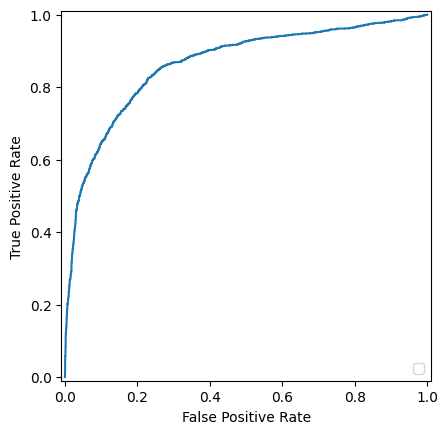

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay(fpr=fpr_norm,tpr=tpr_norm)
display.plot()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


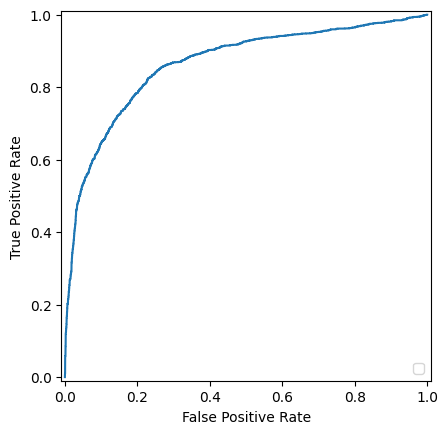

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay(fpr=fpr,tpr=tpr)
display.plot()
plt.show()

In [4]:
test_data

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={
    edge_index=[2, 17681],
    edge_label=[5892],
    edge_label_index=[2, 5892],
  },
  (paper, to, author)={ edge_index=[2, 17681] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

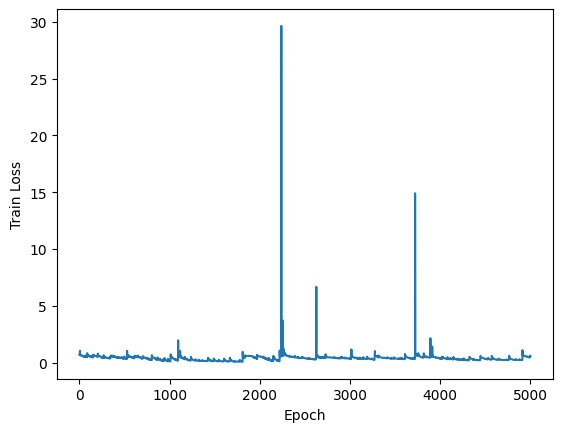

In [ ]:
plt.plot(range(epochs), train_loss_history)
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.show()

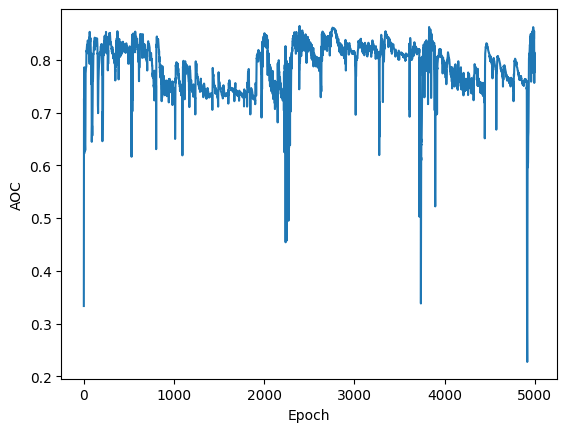

In [ ]:
plt.plot(range(epochs), val_loss_history)
plt.ylabel('AOC')
plt.xlabel('Epoch')
plt.show()